### 1. Instalação e importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ferramentas do Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Configuração de visualização
sns.set(style="whitegrid")

### 2.Carregar e Limpar os Dados

In [2]:
# Carregando os dados (use o caminho do seu arquivo)
caminho = '/home/seiji/Documentos/Ebanx/ProjetoGeral/Saude-Mental-Curitiba-Regiao/notebooks/dados_cheirosos.csv'
df = pd.read_csv(caminho)

# --- LIMPEZA CRÍTICA (Evitar Data Leakage) ---
cols_descarte = ['quantidade_atendimentos', 'quantidade_aprovada_procedimento']
df_limpo = df.drop(columns=cols_descarte)

print(f"Dataset carregado com {df_limpo.shape[0]} linhas e {df_limpo.shape[1]} colunas.")
df_limpo.head()

Dataset carregado com 342568 linhas e 10 colunas.


,ano_atendimento,mes_atendimento,sexo_paciente,raca_cor_paciente,cid_categoria_geral,municipio_atendimento,municipio_residencia,faixa_etaria,estabelecimento_cnes,procedimento_ambulatorial
0,2014,1,F,branca,Deficiência Intelectual,Curitiba,Fazenda Rio Grande,Adolescente (13-18),Centro Psiquiátrico Metropolitano (Curitiba),Atendimento Individual
1,2014,1,F,branca,Comport. Infância/Adolescência (TDAH),Curitiba,Campo Magro,Adolescente (13-18),Centro Psiquiátrico Metropolitano (Curitiba),Atendimento Individual
2,2014,1,F,parda,Comport. Infância/Adolescência (TDAH),Curitiba,Piraquara,Adolescente (13-18),Centro Psiquiátrico Metropolitano (Curitiba),Atendimento Individual
3,2014,1,M,branca,Deficiência Intelectual,Curitiba,Fazenda Rio Grande,Adolescente (13-18),Centro Psiquiátrico Metropolitano (Curitiba),Atendimento Individual
4,2014,1,M,branca,Desenv. Psicológico,Curitiba,Colombo,Adolescente (13-18),Centro Psiquiátrico Metropolitano (Curitiba),Atendimento Individual


### 3. Agrupamento Estratégico

In [3]:
# Definir o mapa de redução de classes para simplificar o problema
mapa_agrupamento = {
    # Manter o gigante separado
    'Atendimento Individual': 'Individual',
    
    # Agrupar Coletivos
    'Atendimento em Grupo': 'Coletivo',
    'Atendimento Familiar': 'Coletivo',
    
    # Agrupar Entrada/Urgência
    'Acolhimento Diurno': 'Acolhimento_Crise',
    'Acolhimento Noturno': 'Acolhimento_Crise',
    'Acolhimento em Terceiro Turno': 'Acolhimento_Crise',
    'Atenção às Situações de Crise': 'Acolhimento_Crise',
    
    # Agrupar Reabilitação e Oficinas
    'Ações de Reabilitação Psicossocial': 'Reabilitacao_Praticas',
    'Práticas Corporais': 'Reabilitacao_Praticas',
    'Práticas Expressivas e Comunicativas': 'Reabilitacao_Praticas',
    'Promoção de Contratualidade no Território': 'Reabilitacao_Praticas',
    
    # Agrupar Atendimentos Externos
    'Atendimento Domiciliar': 'Externo',
    'Acompanhamento de Paciente em Residência Terapêutica': 'Externo'
}

# Aplicar o mapa na coluna alvo original
# Isso substitui os 13 nomes pelos 5 novos grupos
df_limpo['target_agrupado'] = df_limpo['procedimento_ambulatorial'].map(mapa_agrupamento)

# Verificar se deu certo (não pode ter nulos)
print("\nDistribuição após agrupamento:")
print(df_limpo['target_agrupado'].value_counts())


Distribuição após agrupamento:
target_agrupado
Individual               143931
Coletivo                 114594
Reabilitacao_Praticas     41609
Acolhimento_Crise         29737
Externo                   12697
Name: count, dtype: int64


### 4. Preparação

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector

# 1. Separar X e y (Usando o alvo agrupado)
X = df_limpo.drop(columns=['procedimento_ambulatorial', 'target_agrupado'])
y = df_limpo['target_agrupado']

# 2. Encoder do Alvo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identificar colunas automaticamente
categoricas_cols = make_column_selector(dtype_include=object)(X)
numericas_cols = make_column_selector(dtype_include=np.number)(X)

# Criar índices das colunas categóricas para o modelo saber (boolean mask)

preprocessor_turbo = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericas_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categoricas_cols)
    ],
    verbose_feature_names_out=False
).set_output(transform="pandas") # Importante para manter nomes das colunas

### 5. Divisão E Treino

Treinando Modelo Otimizado (Native Boosting)...

=== Resultado Otimizado ===
                       precision    recall  f1-score   support

    Acolhimento_Crise       0.39      0.12      0.18      7434
             Coletivo       0.49      0.46      0.47     28649
              Externo       0.49      0.19      0.28      3174
           Individual       0.53      0.73      0.61     35983
Reabilitacao_Praticas       0.37      0.21      0.27     10402

             accuracy                           0.50     85642
            macro avg       0.45      0.34      0.36     85642
         weighted avg       0.48      0.50      0.47     85642



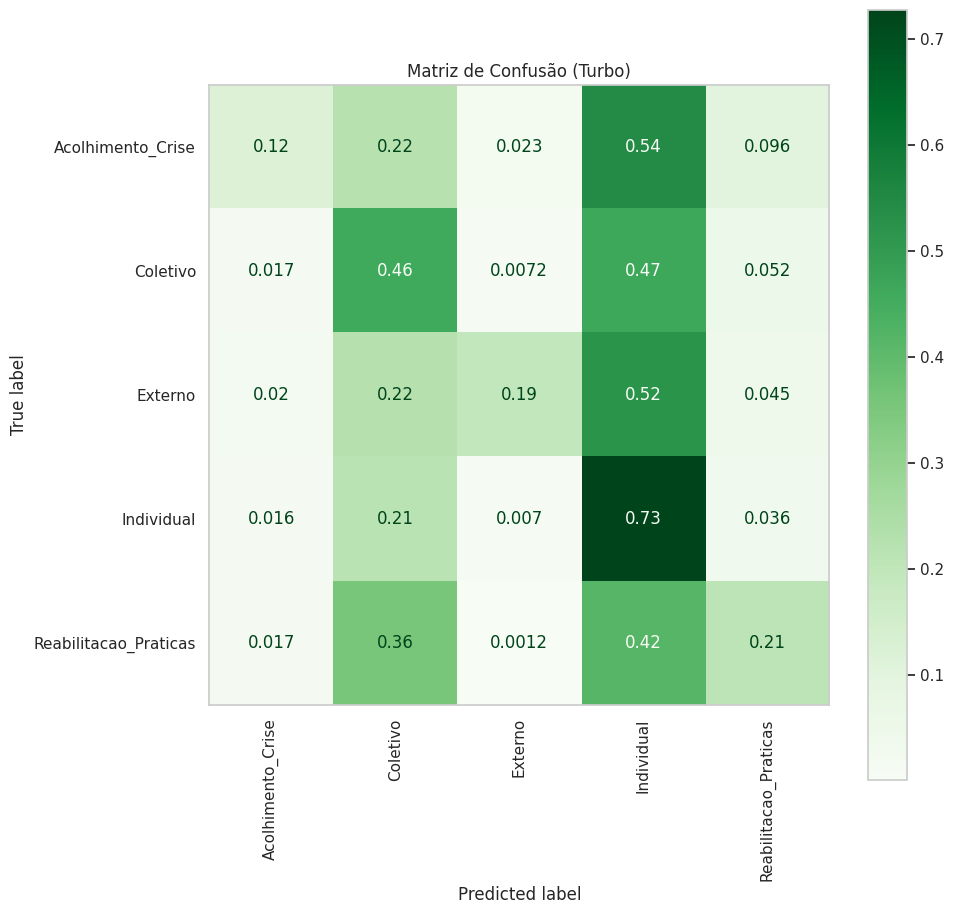

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

# 4. Pipeline Turbo
# O HistGradientBoosting aceita o parâmetro categorical_features='from_dtype'
# se passarmos um DataFrame pandas onde as categorias são do tipo 'category',
# O jeito é deixar ele tratar os Ordinais como numéricos contínuos ou 
# usar a implementação nativa sem pipeline complexo, mas vamos manter o pipeline pela segurança.

pipeline_turbo = Pipeline([
    ('preprocessor', preprocessor_turbo),
    ('clf', HistGradientBoostingClassifier(
        categorical_features='from_dtype', # Vai tentar detectar automaticamente se passarmos o tipo certo
        max_iter=300,           # Mais iterações
        learning_rate=0.05,     # Aprender mais devagar (melhora generalização)
        max_depth=15,           # Árvores mais profundas
        l2_regularization=1.0,  # Evitar overfitting
        early_stopping=True,    # Parar se não melhorar
        scoring='f1_weighted',
        random_state=42
    ))
])

print("Treinando Modelo Otimizado (Native Boosting)...")
pipeline_turbo.fit(X_train, y_train)

# 5. Avaliar
y_pred_turbo = pipeline_turbo.predict(X_test)

print("\n=== Resultado Otimizado ===")
print(classification_report(y_test, y_pred_turbo, target_names=le.classes_))

# Matriz de Confusão
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_turbo, 
    display_labels=le.classes_, 
    xticks_rotation='vertical',
    ax=ax,
    cmap='Greens', # Mudei a cor pra diferenciar
    normalize='true'
)
plt.title("Matriz de Confusão (Turbo)")
plt.grid(False)
plt.show()

### 6. Avaliação


=== Relatório de Classificação (Grupos Simplificados) ===
                       precision    recall  f1-score   support

    Acolhimento_Crise       0.39      0.12      0.18      7434
             Coletivo       0.49      0.46      0.47     28649
              Externo       0.49      0.19      0.28      3174
           Individual       0.53      0.73      0.61     35983
Reabilitacao_Praticas       0.37      0.21      0.27     10402

             accuracy                           0.50     85642
            macro avg       0.45      0.34      0.36     85642
         weighted avg       0.48      0.50      0.47     85642



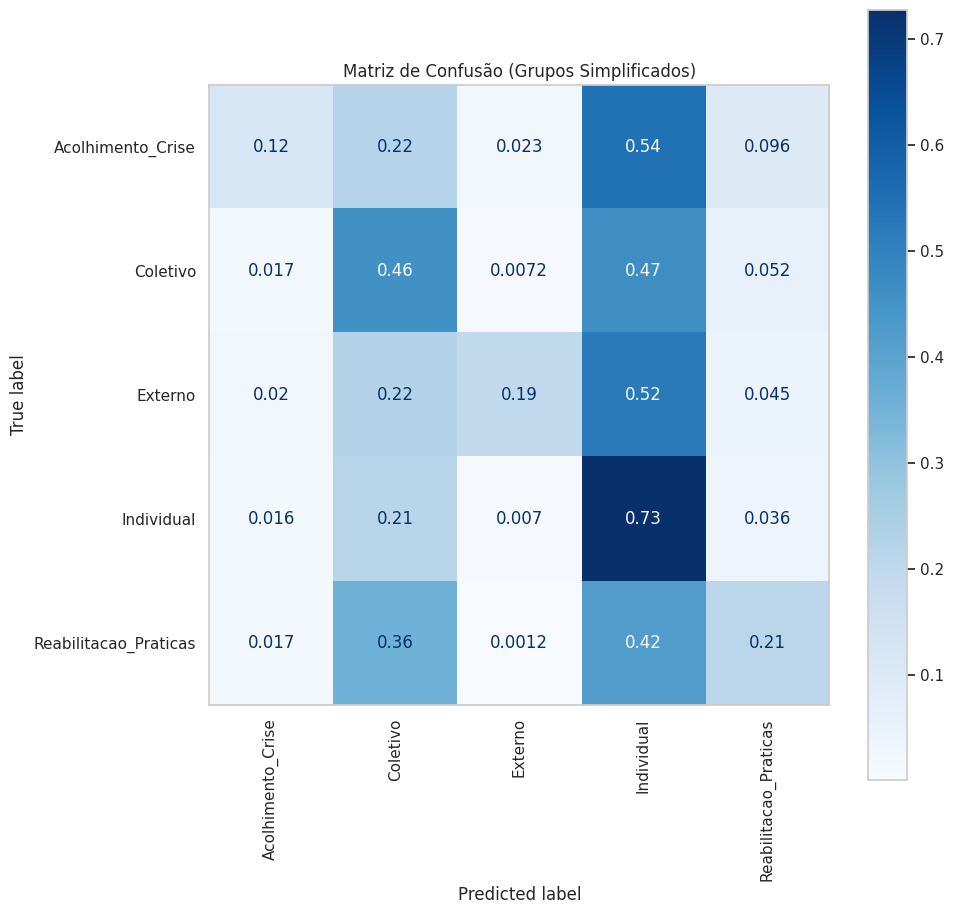

In [8]:
# Previsões
y_pred = pipeline_turbo.predict(X_test)

# Relatório de Classificação
print("\n=== Relatório de Classificação (Grupos Simplificados) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de Confusão
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=le.classes_, 
    xticks_rotation='vertical',
    ax=ax,
    cmap='Blues',
    normalize='true'
)
plt.title("Matriz de Confusão (Grupos Simplificados)")
plt.grid(False)
plt.show()

Nivelando todas as classes para ter 12697 exemplos cada.
target_agrupado
Individual               12697
Coletivo                 12697
Externo                  12697
Acolhimento_Crise        12697
Reabilitacao_Praticas    12697
Name: count, dtype: int64

Treinando com Undersampling...

=== Resultado com Balanceamento Radical ===
                       precision    recall  f1-score   support

    Acolhimento_Crise       0.44      0.50      0.47      3809
             Coletivo       0.45      0.30      0.36      3809
              Externo       0.54      0.51      0.52      3809
           Individual       0.41      0.37      0.39      3810
Reabilitacao_Praticas       0.43      0.56      0.49      3809

             accuracy                           0.45     19046
            macro avg       0.45      0.45      0.45     19046
         weighted avg       0.45      0.45      0.45     19046



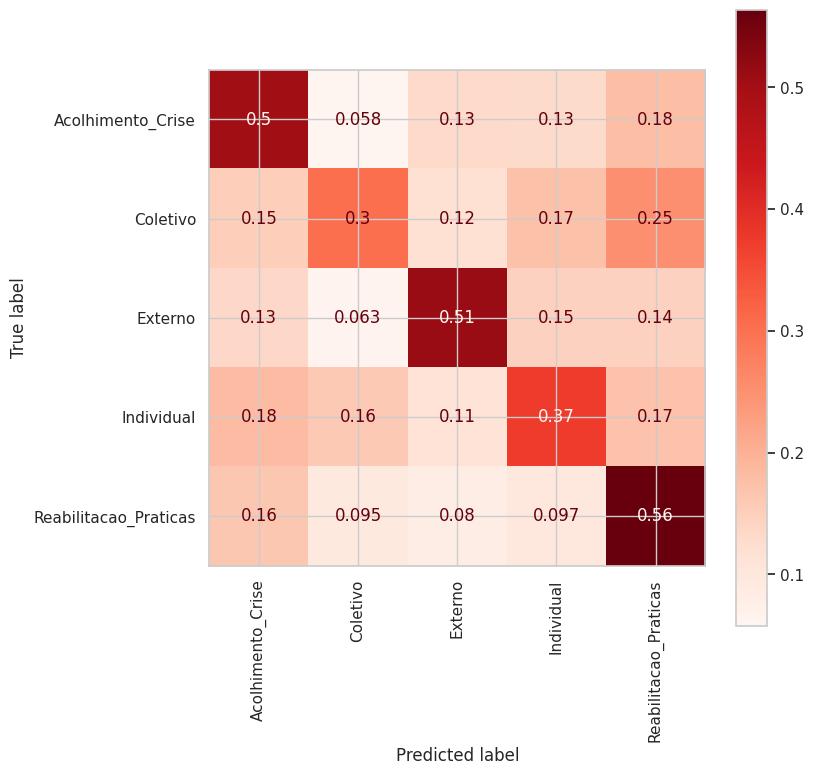

In [12]:
from sklearn.utils import resample

# 1. Juntar X e y num dataframe temporário para fazer a amostragem
df_temp = df_limpo.copy()

# 2. Descobrir o tamanho da menor classe
tamanho_menor_classe = df_temp['target_agrupado'].value_counts().min()
print(f"Nivelando todas as classes para ter {tamanho_menor_classe} exemplos cada.")

# 3. Criar um novo dataframe balanceado 'na marra'
df_balanceado = pd.DataFrame()

for classe in df_temp['target_agrupado'].unique():
    df_classe = df_temp[df_temp['target_agrupado'] == classe]
    # Pega uma amostra aleatória do tamanho da menor classe
    df_resample = resample(df_classe, 
                           replace=False, 
                           n_samples=tamanho_menor_classe, 
                           random_state=42)
    df_balanceado = pd.concat([df_balanceado, df_resample])

# 4. Verificar nova distribuição (deve ser tudo igual)
print(df_balanceado['target_agrupado'].value_counts())

# --- RE-TREINAR COM DADOS NIVELADOS ---

# Separar X e y do novo dataframe
X_bal = df_balanceado.drop(columns=['procedimento_ambulatorial', 'target_agrupado'])
y_bal = df_balanceado['target_agrupado']

# Encoder
le = LabelEncoder()
y_bal_encoded = le.fit_transform(y_bal)

# Split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bal, y_bal_encoded, test_size=0.3, random_state=42, stratify=y_bal_encoded)

# Treinar (Usando o Random Forest que é mais estável para poucos dados)
# NÃO precisamos mais de class_weight='balanced' porque já balanceamos manualmente
pipeline_final = Pipeline([
    ('preprocessor', preprocessor_turbo), # Volta para o OneHotEncoder (mais seguro aqui)
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))
])

print("\nTreinando com Undersampling...")
pipeline_final.fit(X_train_b, y_train_b)

# Avaliar
y_pred_bal = pipeline_final.predict(X_test_b)

print("\n=== Resultado com Balanceamento Radical ===")
print(classification_report(y_test_b, y_pred_bal, target_names=le.classes_))

# Matriz
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test_b, y_pred_bal, 
    display_labels=le.classes_, 
    xticks_rotation='vertical',
    ax=ax,
    cmap='Reds',
    normalize='true'
)
plt.show()

Distribuição Binária:
target_binario
0    0.579847
1    0.420153
Name: proportion, dtype: float64

Treinando Classificação Binária (Individual vs O Resto)...

=== Relatório Binário ===
                 precision    recall  f1-score   support

Coletivo/Outros       0.64      0.70      0.67     59591
     Individual       0.52      0.45      0.48     43180

       accuracy                           0.60    102771
      macro avg       0.58      0.58      0.58    102771
   weighted avg       0.59      0.60      0.59    102771



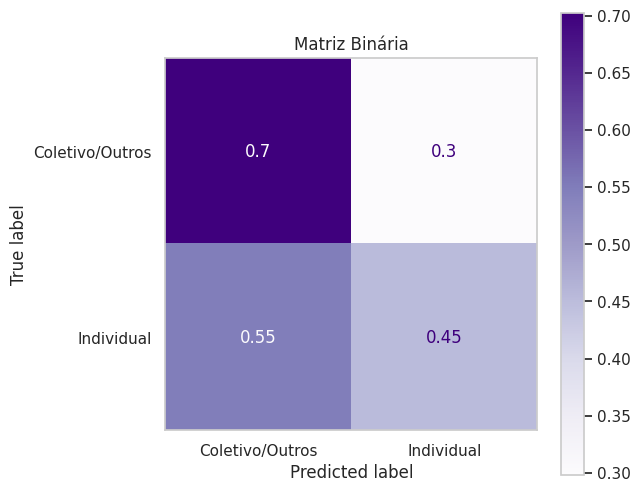

In [14]:
# --- ESTRATÉGIA BINÁRIA (A ÚLTIMA TENTATIVA) ---

# 1. Criar alvo binário: 1 = Individual, 0 = Qualquer outro (Coletivo/Crise/etc)
# Vamos usar o dataframe original limpo (sem o undersampling, para ter bastante dado)
df_binario = df_limpo.copy()

# Se for Individual vira 1, se não vira 0
df_binario['target_binario'] = np.where(df_binario['procedimento_ambulatorial'] == 'Atendimento Individual', 1, 0)

# 2. Verificar distribuição
print("Distribuição Binária:")
print(df_binario['target_binario'].value_counts(normalize=True))

# 3. Preparação
X_bin = df_binario.drop(columns=['procedimento_ambulatorial', 'target_agrupado', 'target_binario'])
y_bin = df_binario['target_binario']

# 4. Split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin)

# 5. Treinar Random Forest (Binário)
# Não precisamos de balanceamento agressivo aqui, a proporção é 42% vs 58% (saudável)
pipeline_binario = Pipeline([
    ('preprocessor', preprocessor_turbo), # Volta pro OneHot ou Ordinal, tanto faz
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42)) 
])

print("\nTreinando Classificação Binária (Individual vs O Resto)...")
pipeline_binario.fit(X_train_bin, y_train_bin)

# 6. Avaliar
y_pred_bin = pipeline_binario.predict(X_test_bin)

print("\n=== Relatório Binário ===")
print(classification_report(y_test_bin, y_pred_bin, target_names=['Coletivo/Outros', 'Individual']))

# Matriz
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_pred_bin, 
    display_labels=['Coletivo/Outros', 'Individual'], 
    cmap='Purples',
    normalize='true',
    ax=ax
)
plt.title("Matriz Binária")
plt.grid(False)
plt.show()